<a href="https://colab.research.google.com/github/probml/dynamax/blob/main/dynamax/rebayes/demos/orfit_1d_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ORFit Regression Demo

# 0. Imports

In [3]:
# %pip install augly
# %pip install pylibmagic
# %pip install flax
# %pip install tqdm
# %pip install -qq git+https://github.com/probml/dynamax.git

In [1]:
from typing import Sequence
from functools import partial
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import jacrev
from jax import vmap
import flax.linen as nn
from jax.flatten_util import ravel_pytree
from tensorflow_probability.substrates.jax.distributions import Normal
from tqdm import tqdm, trange

import pylibmagic
from dynamax.utils.datasets import load_1d_synthetic_dataset, load_rotated_mnist
from dynamax.rebayes.ekf import RebayesEKF
from dynamax.generalized_gaussian_ssm.models import ParamsGGSSM
from dynamax.rebayes.orfit import ORFitParams, orthogonal_recursive_fitting, PosteriorORFitFiltered

# 1. MLP Model and Posterior Predictive

## 1.1 MLP

In [2]:
# Define MLP model that uses gelu activation function
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = nn.gelu(nn.Dense(feat)(x))
        x = nn.Dense(self.features[-1])(x)
        return x

def get_mlp_flattened_params(model_dims, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)

    # Define MLP model
    input_dim, features = model_dims[0], model_dims[1:]
    model = MLP(features)
    dummy_input = jnp.ones((input_dim,))

    # Initialize parameters using dummy input
    params = model.init(key, dummy_input)
    flat_params, unflatten_fn = ravel_pytree(params)

    # Define apply function
    def apply(flat_params, x, model, unflatten_fn):
        return model.apply(unflatten_fn(flat_params), jnp.atleast_1d(x))

    apply_fn = partial(apply, model=model, unflatten_fn=unflatten_fn)

    return model, flat_params, unflatten_fn, apply_fn

## 1.2 ORFit Posterior Predictive

In [3]:
def orfit_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_basis):
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    FU = F @ post_basis
    pred_cov = F @ F.T - FU @ FU.T

    return pred_mean, pred_cov

In [4]:
def orfit_plot_prediction(ax, post_mean, post_basis, apply_fn, featurize_fn, 
                          X_train, y_train, X_eval, y_eval, obs_noise=False, 
                          plot_title=''):
    # Predict
    X_features = vmap(featurize_fn)(X_eval)
    pred_means, pred_covs = vmap(
        orfit_posterior_predictive_moments, (None, 0, None, None)
    )(apply_fn, X_features, post_mean, post_basis)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    ax.plot(X_eval, pred_means, label='mean');
    if obs_noise:
        ax.scatter(X_train, y_train, c='k', label='data', alpha=0.8);
    else:
        ax.plot(X_eval, y_eval, 'r--', label='true function')
        ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0*jnp.sqrt(pred_covs), 
                    pred_means + 2.0*jnp.sqrt(pred_covs), alpha=0.5, label='2 std');
    # ax.set_xlim(-3.0, 3.0)
    # ax.set_ylim(-5.0, 3.0)
    ax.set_title(plot_title)
    return ax

## 2.2 EKF Posterior Predictive

In [5]:
def mean_cov_callback(bel, t, x, y):
    return bel.mean, bel.cov

def run_ekf(X, Y, ekf_params, type='fcekf', callback=mean_cov_callback):
    estimator = RebayesEKF(ekf_params, method = type)
    _, filtered_means = estimator.scan(X, Y, callback=callback)

    return filtered_means

In [6]:
def linearized_posterior_predictive_moments_diagonal(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = (F * post_cov) @ F.T + obs_noise

    return pred_mean, pred_cov

In [7]:
def linearized_posterior_predictive_moments(apply_fn, x_to_pred, post_mean, post_cov, obs_noise=0.0):
    """Compute posterior predictive moments for a single input x_to_pred"""
    apply = lambda w: apply_fn(w, x_to_pred)

    # Compute posterior predictive mean
    pred_mean = apply(post_mean)

    # Compute posterior predictive covariance
    F = jacrev(apply)(post_mean)
    pred_cov = F @ post_cov @ F.T + obs_noise

    return pred_mean, pred_cov


In [8]:
def plot_predictions(X_train, y_train, X_eval, initial_var, emission_var, 
                     flat_params, apply_fn, ekf_type='fcekf'):
    state_dim = flat_params.size
    ekf_params = ParamsGGSSM(
        initial_mean=flat_params,
        initial_covariance=jnp.eye(state_dim) * initial_var,
        dynamics_function=lambda w, _: w,
        dynamics_covariance = jnp.eye(state_dim) * 0,
        emission_mean_function = lambda w, x: apply_fn(w, x),
        emission_cov_function = lambda w, x: jnp.array([emission_var]),
    )
    # Train EKF
    ekf_post = run_ekf(X_train, y_train, ekf_params, type=ekf_type)
    ekf_mean, ekf_cov = ekf_post[0][-1], ekf_post[1][-1]

    # Predict
    if len(ekf_cov.shape) == 2:
        posterior_predictive_fn = linearized_posterior_predictive_moments
    else:
        posterior_predictive_fn = linearized_posterior_predictive_moments_diagonal
    pred_means, pred_covs = vmap(
        posterior_predictive_fn, (None, 0, None, None, None)
    )(apply_fn, X_eval, ekf_mean, ekf_cov, emission_var)
    pred_means, pred_covs = pred_means.squeeze(), pred_covs.squeeze()

    # Plot predictions
    fig, ax = plt.subplots()
    ax.plot(X_eval, pred_means, label='mean');
    ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0 * jnp.sqrt(pred_covs), pred_means + 2.0 * jnp.sqrt(pred_covs), alpha=0.5, label='2 std');
    # ax.set_xlim(-3.0, 3.0)
    # ax.set_ylim(-3.0, 3.0)
    ax.set_title(f'{ekf_type.upper()} predictions')

In [9]:
def plot_ensemble_predictions(ax, post_means, apply_fn, X_train, y_train, X_eval, plot_title=''):
    pred_means = vmap(vmap(apply_fn, (0, None)), (None, 0))(post_means, X_eval)
    pred_covs = jnp.var(pred_means, axis=1).squeeze()
    pred_means = jnp.mean(pred_means, axis=1).squeeze()

    # Plot predictions
    ax.plot(X_eval, pred_means, label='mean');
    ax.plot(X_train, y_train, 'kx', label='data', alpha=0.8);
    ax.fill_between(X_eval.squeeze(), pred_means - 2.0 * jnp.sqrt(pred_covs), pred_means + 2.0 * jnp.sqrt(pred_covs), alpha=0.5, label='2 std');
    # ax.set_xlim(-3.0, 3.0)
    # ax.set_ylim(-3.0, 3.0)
    ax.set_title(plot_title)
    
    return ax

# 2. Linear Regression

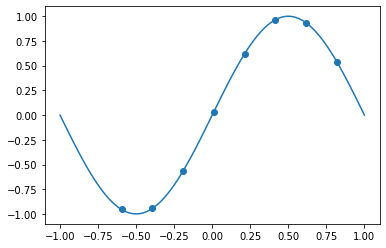

In [10]:
# Sinusoidal Dataset
n1_samples = 100
X1_grid = jnp.linspace(-1.0, 1.0, n1_samples)
y1_true = jnp.sin(jnp.pi*X1_grid)

# Select some samples as training set
sampled_indices = jr.permutation(jr.PRNGKey(0), jnp.arange(n1_samples//5, n1_samples, 10))
n1_train = len(sampled_indices)
X1_train, y1_train = X1_grid[sampled_indices], y1_true[sampled_indices]

fig, ax = plt.subplots()
ax.plot(X1_grid, y1_true)
ax.scatter(X1_train, y1_train);

In [11]:
# Feature set is polynomial of order 20
poly_order1 = 20
def x_to_feature(x, order=poly_order1):
    return jnp.power(x, jnp.arange(1, order+1))

X1_featurized = vmap(x_to_feature)(X1_train)

In [12]:
# Define the linear regression model
input_dim1, hidden_dims1, output_dim1 = poly_order1, [], 1
model_dims1 = [input_dim1, *hidden_dims1, output_dim1]
_, flat_params1, _, apply_fn1 = get_mlp_flattened_params(model_dims1)
print(flat_params1.shape)

(21,)


In [13]:
# Train ORFit on the dataset
orfit_params1 = ORFitParams(
    initial_mean=flat_params1,
    apply_function=apply_fn1,
    loss_function=lambda w, x, y: (apply_fn1(w, x) - y) ** 2,
    memory_size=n1_train
)
orfit_posterior1 = orthogonal_recursive_fitting(orfit_params1, y1_train, X1_featurized)

In [14]:
def animate_orfit(orfit_posterior, apply_fn, featurize_fn, X_train, y_train, 
                  X_grid, y_true, obs_noise, total_iter, i):
    filtered_means, filtered_bases = orfit_posterior.filtered_means, orfit_posterior.filtered_bases

    ax.cla()

    orfit_plot_prediction(ax, filtered_means[i], filtered_bases[i], apply_fn, 
                          featurize_fn, X_train[:i+1], y_train[:i+1], X_grid, y_true, 
                          obs_noise=obs_noise, plot_title=f'ORFit (Training Data {i+1}/{total_iter})')
    ax.set_ylim(-3.0, 3.0)
    
    return ax

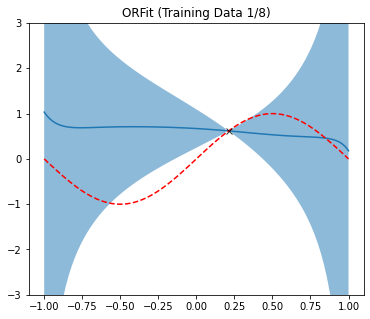

In [15]:
animate_lr1 = lambda i: animate_orfit(orfit_posterior1, apply_fn1, x_to_feature, 
                                      X1_train, y1_train, X1_grid, y1_true, False, 
                                      n1_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim1 = animation.FuncAnimation(fig, animate_lr1, frames=n1_train, interval=600)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [16]:
HTML(anim1.to_html5_video())

# 3. Non-Linear Regression

## 3.0 Datasets

In [18]:
n2_train=200
n2_test=400

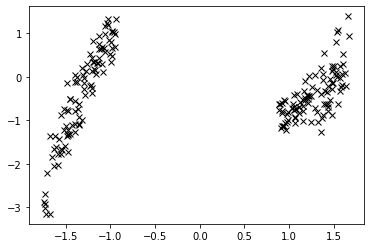

In [19]:
# Dataset 1
(X2_train, y2_train), (X2_test, y2_test) = load_1d_synthetic_dataset(n_train=n2_train, n_test=n2_test)
X2_train, y2_train = X2_train.squeeze(), y2_train.squeeze()
shuffle_indx = jr.permutation(jr.PRNGKey(0), jnp.arange(X2_train.shape[0]))
X2_train, y2_train = X2_train[shuffle_indx], y2_train[shuffle_indx]
X2_grid = jnp.linspace(-2.5, 2.5, 200)

fig, ax = plt.subplots()
ax.plot(X2_train, y2_train, 'kx', label='data');
# ax.plot(X2_test, y2_test, 'rx', label='data');
# ax.set_xlim(-0.5, 1.0)
# ax.set_ylim(-0.5, 1.0);

## 3.1 Simple MLP

### 3.1.1 PPD Sweep over Memory Size

In [ ]:
# Define the MLP model
input_dim2, hidden_dims2, output_dim2 = 1, [50,], 1
model_dims2 = [input_dim2, *hidden_dims2, output_dim2]
_, flat_params2, _, apply_fn2 = get_mlp_flattened_params(model_dims2)
print(flat_params2.shape)

(151,)


In [ ]:
def animate_per_memory_size(flat_params, apply_fn, X_train, y_train, X_grid, y_llim, y_ulim, i, mlp_type):
    ax.cla()
    # Train ORFit on the dataset
    orfit_params = ORFitParams(
        initial_mean=flat_params,
        apply_function=apply_fn,
        loss_function=lambda w, x, y: (apply_fn(w, x) - y) ** 2,
        memory_size=i+1
    )
    before = time.time()
    orfit_posterior = orthogonal_recursive_fitting(orfit_params, y_train, X_train)
    orfit_filtered_mean = orfit_posterior.filtered_means[-1]
    orfit_filtered_basis = orfit_posterior.filtered_bases[-1]
    clear_output(wait=True)
    print(f'Time taken for step {i+1}: {time.time() - before}')
    orfit_plot_prediction(ax, orfit_filtered_mean, orfit_filtered_basis, apply_fn, lambda x: x,
                          X_train, y_train, X_grid, None, True, 
                          plot_title=f'ORFit-{mlp_type} MLP (Memory Size {i+1}/100)')
    ax.set_ylim(y_llim, y_ulim)
    
    return ax

animate_nlr1 = lambda i: animate_per_memory_size(flat_params2, apply_fn2, X2_train, y2_train, X2_grid, -6.0, 5.0, i, 'Simple')

Time taken for step 1: 0.6665101051330566


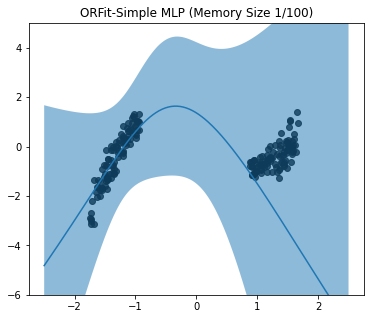

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
anim2 = animation.FuncAnimation(fig, animate_nlr1, frames=100)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [ ]:
HTML(anim2.to_html5_video())

Time taken for step 100: 0.8198974132537842


### 3.1.2 PPD Sweep over Training Set

#### 3.1.2.1 Memory Size 10

In [ ]:
# Train Full-Memory ORFit on the dataset
orfit_params2 = ORFitParams(
    initial_mean=flat_params2,
    apply_function=apply_fn2,
    loss_function=lambda w, x, y: (apply_fn2(w, x) - y) ** 2,
    memory_size=10
)
orfit_posterior2 = orthogonal_recursive_fitting(orfit_params2, y2_train, X2_train)

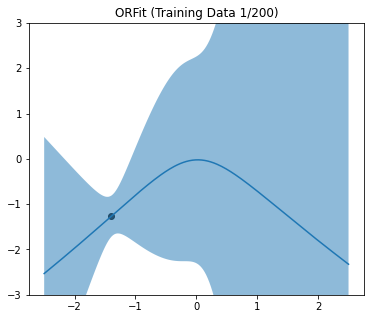

In [ ]:
animate_nlr2 = lambda i: animate_orfit(orfit_posterior2, apply_fn2, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim3 = animation.FuncAnimation(fig, animate_nlr2, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [ ]:
HTML(anim3.to_html5_video())

#### 3.1.2.2 Inifinite Memory

In [ ]:
# Train Full-Memory ORFit on the dataset
orfit_params3 = ORFitParams(
    initial_mean=flat_params2,
    apply_function=apply_fn2,
    loss_function=lambda w, x, y: (apply_fn2(w, x) - y) ** 2,
    memory_size=n2_train
)
orfit_posterior3 = orthogonal_recursive_fitting(orfit_params3, y2_train, X2_train)

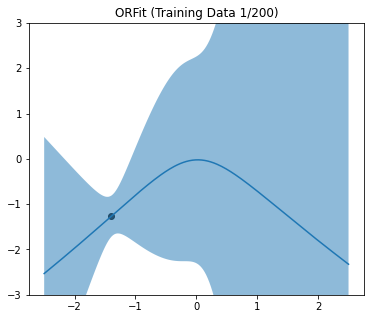

In [ ]:
animate_nlr3 = lambda i: animate_orfit(orfit_posterior3, apply_fn2, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim4 = animation.FuncAnimation(fig, animate_nlr3, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [ ]:
HTML(anim4.to_html5_video())

## 3.2 Deeper/Wider MLP

### 3.2.1 PPD Sweep over Memory Size

In [ ]:
# Define the MLP model
input_dim3, hidden_dims3, output_dim3 = 1, [150, 150, 150,], 1
model_dims3 = [input_dim3, *hidden_dims3, output_dim3]
_, flat_params3, _, apply_fn3 = get_mlp_flattened_params(model_dims3)
print(flat_params3.shape)

(45751,)


In [ ]:
animate_nlr4 = lambda i: animate_per_memory_size(flat_params3, apply_fn3, X2_train, y2_train, X2_grid, -6.0, 5.0, i, 'Complex')

Time taken for step 1: 1.678701639175415


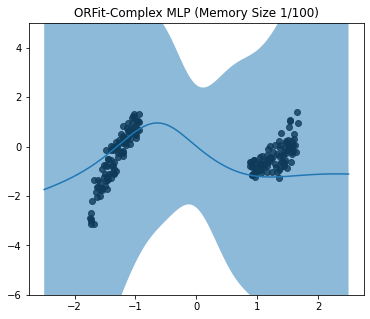

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
anim5 = animation.FuncAnimation(fig, animate_nlr4, frames=100)
# anim.save("orfit_mlp1.mp4", dpi=200, bitrate=-1, fps=24)

In [ ]:
HTML(anim5.to_html5_video())

Time taken for step 100: 10.841744899749756


### 3.2.2 PPD Sweep over Training Set

#### 3.2.2.1 Memory Size 25

In [ ]:
# Train Full-Memory ORFit on the dataset
orfit_params4 = ORFitParams(
    initial_mean=flat_params3,
    apply_function=apply_fn3,
    loss_function=lambda w, x, y: (apply_fn3(w, x) - y) ** 2,
    memory_size=25
)
orfit_posterior4 = orthogonal_recursive_fitting(orfit_params4, y2_train, X2_train)

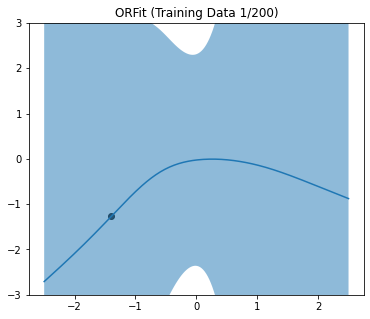

In [ ]:
animate_nlr5 = lambda i: animate_orfit(orfit_posterior4, apply_fn3, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim6 = animation.FuncAnimation(fig, animate_nlr5, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [ ]:
HTML(anim6.to_html5_video())

#### 3.2.2.2 Infinite Memory

In [ ]:
# Train Full-Memory ORFit on the dataset
orfit_params5 = ORFitParams(
    initial_mean=flat_params3,
    apply_function=apply_fn3,
    loss_function=lambda w, x, y: (apply_fn3(w, x) - y) ** 2,
    memory_size=n2_train
)
orfit_posterior5 = orthogonal_recursive_fitting(orfit_params5, y2_train, X2_train)

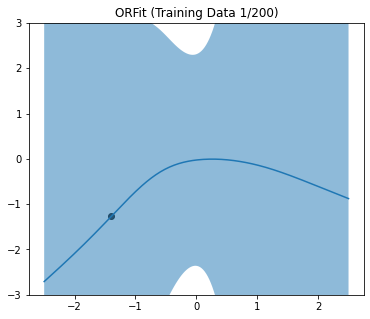

In [ ]:
animate_nlr6 = lambda i: animate_orfit(orfit_posterior5, apply_fn3, lambda x: x, 
                                       X2_train, y2_train, X2_grid, None, True, 
                                       n2_train, i)

fig, ax = plt.subplots(figsize=(6, 5))
anim7 = animation.FuncAnimation(fig, animate_nlr6, frames=n2_train)
# anim.save("orfit1_mlp1.mp4", dpi=200, bitrate=-1, fps=12)

In [ ]:
HTML(anim7.to_html5_video())

# 4. Ensemble ORFit

In [ ]:
def generate_ensemble_orfit(model_dims, memory_size, num_models=20, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key, subkey = jr.split(key)

    def generate_orfit(key):
        _, flat_params, _, apply_fn = get_mlp_flattened_params(model_dims, key)
        orfit_params = ORFitParams(
            initial_mean=flat_params,
            apply_function=apply_fn,
            loss_function=lambda w, x, y: (apply_fn(w, x) - y) ** 2,
            memory_size=memory_size
        )
        return flat_params, orfit_params
    
    ensemble_orfit = []
    priors = []
    for _ in range(num_models):
        key, subkey = jr.split(subkey)
        flat_params, orfit_params = generate_orfit(key)
        priors.append(PosteriorORFitFiltered(
            filtered_means=flat_params,
            filtered_bases=jnp.zeros((flat_params.size, memory_size,))
        ))
        ensemble_orfit.append(orfit_params)

    return priors, ensemble_orfit

## 4.1 Aggregation Model

In [ ]:
# Run Ensemble ORFit (Memory size=25, number of models in ensemble=20)
priors, ensemble_orfit = generate_ensemble_orfit(model_dims2, 25, 20)
orfit_posteriors = [orthogonal_recursive_fitting(params, y2_train, X2_train) for params in ensemble_orfit]
orfit_filtered_means = jnp.array([
    jnp.insert(orfit_posteriors[i].filtered_means, 0, priors[i].filtered_means, 0)
     for i in range(len(orfit_posteriors))
])
orfit_filtered_bases = jnp.array([
    jnp.insert(orfit_posteriors[i].filtered_bases, 0, priors[i].filtered_bases, 0)
     for i in range(len(orfit_posteriors))
])

In [ ]:
def animate_ensemble_orfit(orfit_filtered_means, apply_fn, X_train, y_train, 
                           X_grid, total_iter, i, y_llim, y_ulim):
    ax.cla()
    plot_ensemble_predictions(ax, orfit_filtered_means[:,i,:], apply_fn, 
                              X_train[:i], y_train[:i], X_grid, plot_title=f'ORFit (Training Data {i}/{total_iter})')
    ax.set_ylim(y_llim, y_ulim)
    
    return ax

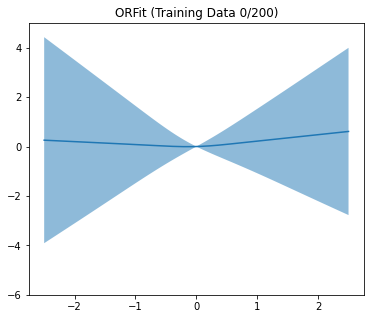

In [ ]:
animate_ensemble = lambda i: animate_ensemble_orfit(
    orfit_filtered_means, apply_fn2, X2_train, y2_train, X2_grid, n2_train, i, -6.0, 5.0
)

fig, ax = plt.subplots(figsize=(6, 5))
anim8 = animation.FuncAnimation(fig, animate_ensemble, frames=n2_train+1)

In [ ]:
HTML(anim8.to_html5_video())

## 4.2 Ranked Model

In [ ]:
def compute_one_step_ahead_lls(post_means, post_bases, apply_fn, X_train, y_train):
    compute_ppd = lambda x, m, b: orfit_posterior_predictive_moments(apply_fn, x, m, b)
    
    means, vars = vmap(
        vmap(
            compute_ppd, (0, 0, 0)
        ), (None, 0, 0)
    )(X_train, post_means[:, :-1, :], post_bases[:, :-1, :])
    means, vars = means.squeeze(), vars.squeeze()

    def compute_ll(mean, var, y):
        return Normal(loc=mean, scale=jnp.sqrt(var)).log_prob(y)
    
    lls = vmap(compute_ll, (1, 1, 0))(means, vars, y_train)
    arg_best_lls = vmap(jnp.argmax, (0))(lls)

    return lls, arg_best_lls

In [ ]:
_, arg_best_lls = compute_one_step_ahead_lls(orfit_filtered_means, orfit_filtered_bases, apply_fn2, X2_train, y2_train)

In [ ]:
def animate_ranked_ensemble_orfit(post_means, post_bases, arg_best_lls, apply_fn, 
                                  X_train, y_train, X_grid, total_iter, i, y_llim, y_ulim):
    ax.cla()
    orfit_plot_prediction(ax, post_means[arg_best_lls[i]][i], post_bases[arg_best_lls[i]][i],
                          apply_fn, lambda x: x, X_train[:i], y_train[:i], X_grid, None, True,
                          plot_title=f'ORFit (Training Data {i+1}/{total_iter})')
    ax.set_ylim(y_llim, y_ulim)
    
    return ax

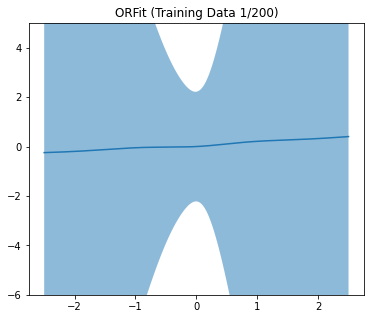

In [ ]:
animate_ranked_ensemble = lambda i: animate_ranked_ensemble_orfit(
    orfit_filtered_means, orfit_filtered_bases, arg_best_lls, 
    apply_fn2, X2_train, y2_train, X2_grid, n2_train, i, -6.0, 5.0
)

fig, ax = plt.subplots(figsize=(6, 5))
anim9 = animation.FuncAnimation(fig, animate_ranked_ensemble, frames=n2_train+1)

In [ ]:
HTML(anim9.to_html5_video())

# 5. Rotating MNIST

In [17]:
np.random.seed(314)
n3_train = 100

(X3_train, y3_train), (X3_test, y3_test) = load_rotated_mnist(target_digit=2)

X3_train = jnp.array(X3_train)[:n3_train]
y3_train = jnp.array(y3_train)[:n3_train]

X3_test = jnp.array(X3_test)
y3_test = jnp.array(y3_test)

X3_train = (X3_train - X3_train.mean()) / X3_train.std()
X3_test = (X3_test - X3_test.mean()) / X3_test.std()

## 5.1 Linear Regression

In [18]:
# Define the MLP model
input_dim4, hidden_dims4, output_dim4 = 784, [], 1
model_dims4 = [input_dim4, *hidden_dims4, output_dim4]
_, flat_params4, _, apply_fn4 = get_mlp_flattened_params(model_dims4)
print(flat_params4.shape)

(785,)


### 5.1.1 NLL

In [53]:
def compute_nll(mean, var, y_true):
    return -Normal(loc=mean, scale=jnp.sqrt(abs(var))).log_prob(y_true)

In [54]:
def compute_average_nlls(apply_fn, means, bases, X_test, y_test):
    pred_means, pred_vars = vmap(
        vmap(orfit_posterior_predictive_moments, (None, None, 0, 0)), (None, 0, None, None)
    )(apply_fn, X_test, means, bases)
    pred_means, pred_vars = pred_means.squeeze(), pred_vars.squeeze()
    nlls = (vmap(compute_nll, (0, 0, 0))(pred_means, pred_vars, y_test)).mean(axis=0)

    return nlls

In [20]:
def train_orfit_and_compute_avg_nll(flat_params, apply_fn, X_train, y_train, X_test, y_test, n_train):
    train_nlls_history, test_nlls_history = [], []
    for i in trange(n_train):
        orfit_params = ORFitParams(
            initial_mean=flat_params,
            apply_function=apply_fn,
            loss_function=lambda w, x, y: (apply_fn(w, x) - y) ** 2,
            memory_size=i+1
        )
        orfit_posterior = orthogonal_recursive_fitting(orfit_params, y_train, X_train)
        filtered_means, filtered_bases = orfit_posterior.filtered_means, orfit_posterior.filtered_bases

        train_nlls = compute_average_nlls(apply_fn, filtered_means, filtered_bases, X_train, y_train)
        test_nlls = compute_average_nlls(apply_fn, filtered_means, filtered_bases, X_test, y_test)
        del orfit_params, orfit_posterior, filtered_means, filtered_bases

        train_nlls_history.append(train_nlls)
        test_nlls_history.append(test_nlls)
    
    return jnp.array(train_nlls_history), jnp.array(test_nlls_history)

In [26]:
# Compute train and test average nlls
train_nlls, test_nlls = train_orfit_and_compute_avg_nll(
    flat_params4, apply_fn4, X3_train, y3_train, X3_test, y3_test, n3_train
)

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [25]:
def animate_nlls_per_memory_size(train_nlls, test_nlls, y_llim, y_ulim, i, mlp_type):
    ax.cla()

    ax.plot(train_nlls[i], label='train set')
    ax.plot(test_nlls[i], label='test set')
    ax.set_ylim(y_llim, y_ulim)
    ax.set_title(f'Average NLLs for memory size {i+1} ({mlp_type} MLP)')
    ax.set_xlabel('Number of training points swept')
    ax.set_ylabel('Average negative log likelihood')
    ax.legend()
    return ax

animate_nlls1 = lambda i: animate_nlls_per_memory_size(train_nlls, test_nlls, 0.0, 8.0, i, 'Linear')

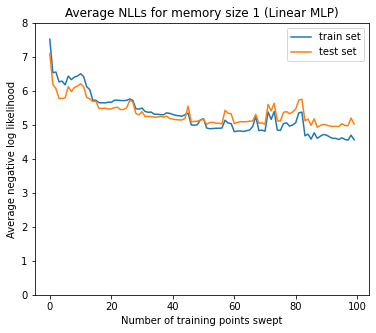

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))
anim8 = animation.FuncAnimation(fig, animate_nlls1, frames=n3_train);

In [30]:
HTML(anim8.to_html5_video())

## 5.2 Nonlinear Regression

In [21]:
# Define the MLP model
input_dim5, hidden_dims5, output_dim5 = 784, [10, 10,], 1
model_dims5 = [input_dim5, *hidden_dims5, output_dim5]
_, flat_params5, _, apply_fn5 = get_mlp_flattened_params(model_dims5)
print(flat_params5.shape)

(7971,)


### 5.2.1 NLL

In [22]:
# Compute train and test average nlls
train_nlls2, test_nlls2 = train_orfit_and_compute_avg_nll(
    flat_params5, apply_fn5, X3_train, y3_train, X3_test, y3_test, n3_train
)

100%|██████████| 100/100 [12:51<00:00,  7.72s/it]


In [23]:
animate_nlls2 = lambda i: animate_nlls_per_memory_size(train_nlls2, test_nlls2, 0.0, 8.0, i, 'Non-Linear')

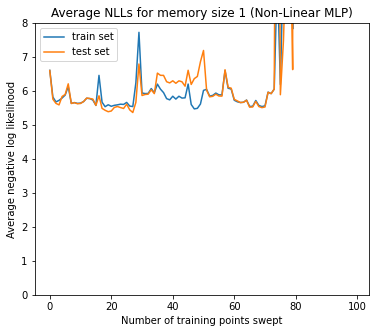

In [26]:
fig, ax = plt.subplots(figsize=(6, 5))
anim9 = animation.FuncAnimation(fig, animate_nlls2, frames=n3_train);

In [27]:
HTML(anim9.to_html5_video())

## 5.3 Ensemble ORFit

In [30]:
# Run Ensemble ORFit (Memory size=25, number of models in ensemble=20)
priors2, ensemble_orfit2 = generate_ensemble_orfit(model_dims5, 25, 20)
orfit_posteriors2 = [orthogonal_recursive_fitting(params, y3_train, X3_train) for params in ensemble_orfit2]
orfit_filtered_means2 = jnp.array([
    jnp.insert(orfit_posteriors2[i].filtered_means, 0, priors2[i].filtered_means, 0)
     for i in range(len(orfit_posteriors2))
])
orfit_filtered_bases2 = jnp.array([
    jnp.insert(orfit_posteriors2[i].filtered_bases, 0, priors2[i].filtered_bases, 0)
     for i in range(len(orfit_posteriors2))
])

In [69]:
def compute_ensemble_nlls(post_means, post_bases, apply_fn, X_eval, y_eval):
    pred_means = vmap(vmap(vmap(apply_fn, (None, 0)), (0, None)), (0, None))(post_means, X_eval).squeeze()
    pred_vars = jnp.var(pred_means, axis=0).squeeze()
    pred_means = jnp.mean(pred_means, axis=0).squeeze()

    nlls = vmap(compute_nll, (1, 1, 0))(pred_means, pred_vars, y_eval).mean(axis=0)
    return nlls

In [70]:
train_nlls = compute_ensemble_nlls(orfit_filtered_means2, orfit_filtered_bases2, apply_fn5, X3_train, y3_train)
test_nlls = compute_ensemble_nlls(orfit_filtered_means2, orfit_filtered_bases2, apply_fn5, X3_test, y3_test)

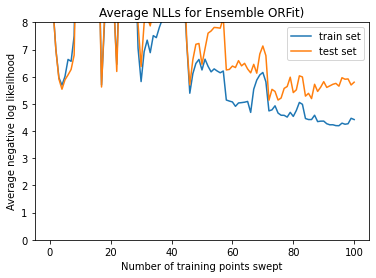

In [75]:
fig, ax = plt.subplots()
ax.plot(train_nlls, label='train set')
ax.plot(test_nlls, label='test set')
ax.set_ylim(0.0, 8.0)
ax.set_title(f'Average NLLs for Ensemble ORFit)')
ax.set_xlabel('Number of training points swept')
ax.set_ylabel('Average negative log likelihood')
ax.legend();